1. nan conversion
2. target, $\mathbf{y\Rightarrow\log(1+y)}$ (`np.log1p`), for normalize fitting; later, back by<br> $\mathbf{y_p \Rightarrow \exp(y_p)-1}$ `(np.expm`)`
- latitude/longitude conversion, a°). knn means, b°). dbscans, then one-hot converstion,<br>
  ```Lasso, 0.7012 ➡︎ 0.6893```
- different models, xgb, lgb, ...
- stack model, blend moder, ...


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook

import seaborn as sns
%matplotlib inline

In [2]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')

In [3]:
import folium

In [4]:
lat=train_df[['lat']].mean()[0]
lon=train_df[['lon']].mean()[0]

In [7]:
# 25.046297901667845 ->-38.02413466665976
lat1=25.046297901667845
# 121.517583 -> 
lon1=121.517583

In [8]:
locations = train_df[['lat', 'lon']].sample(n=1000)
locationlist = locations.values.tolist()
len(locationlist)


1000

In [9]:
locations['lat']=lat1+locations['lat']-lat-0.5+0.1
locations['lon']=locations['lon']+0.5+0.5+1-0.2-0.2

In [ ]:
locations['lat']=locations['lat']+0.3

In [ ]:
locations['lon']=locations['lon']

In [10]:
locationlist = locations.values.tolist()

In [11]:
locations.head(2)

,lat,lon
59434,24.980433,120.92
45851,24.770433,119.68


In [12]:
def conver_lat(df):
    map = folium.Map(location=[lat1,lon1], zoom_start=8)
    df['lon']=df['lon']
    df['lat']=df['lat']
    l=df.values.tolist()
    for point in range(0, len(l)):
        folium.Marker(l[point], popup=train_df['building_id'][point]).add_to(map)
    return df    

In [15]:
def rotate_around_point_lowperf(point, radians, origin=(0, 0)):
    """Rotate a point around a given point.
    
    I call this the "low performance" version since it's recalculating
    the same values more than once [cos(radians), sin(radians), x-ox, y-oy).
    It's more readable than the next function, though.
    """
    #x, y = point
    ox, oy = origin
    xr,yr=[],[]
    for i in range(len(point)) :
        qx = ox + np.cos(radians) * (xy[i][0] - ox) + np.sin(radians) * (xy[i][1] - oy)
        qy = oy + -np.sin(radians) * (xy[i][0]- ox) + np.cos(radians) * (xy[i][1] - oy)
        xr=np.append(xr,qx)
        yr=np.append(yr,qy)
    return xr, yr

In [16]:
x,y=rotate_around_point_lowperf(xy,0.82,origin=(24.670433,119.76))

In [17]:
locations_r=locations.copy()
locations_r['lat']=x-0.8
locations_r['lon']=y+0.8

In [18]:
m=conver_lat(locations_r)


In [19]:
map = folium.Map(location=[lat1,lon1], zoom_start=7)
l=m.values.tolist()
for point in range(0, len(m)):
    folium.Marker(l[point], popup=train_df['building_id'][point]).add_to(map)
map    

In [149]:
map.save("folium.html")

Cluster by kmeans
---

In [23]:
from sklearn.cluster import KMeans
from collections import Counter

In [24]:
# divide into 16 neighbors
id_n=16
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X)
# classify X by KNN 
id_label=kmeans.labels_

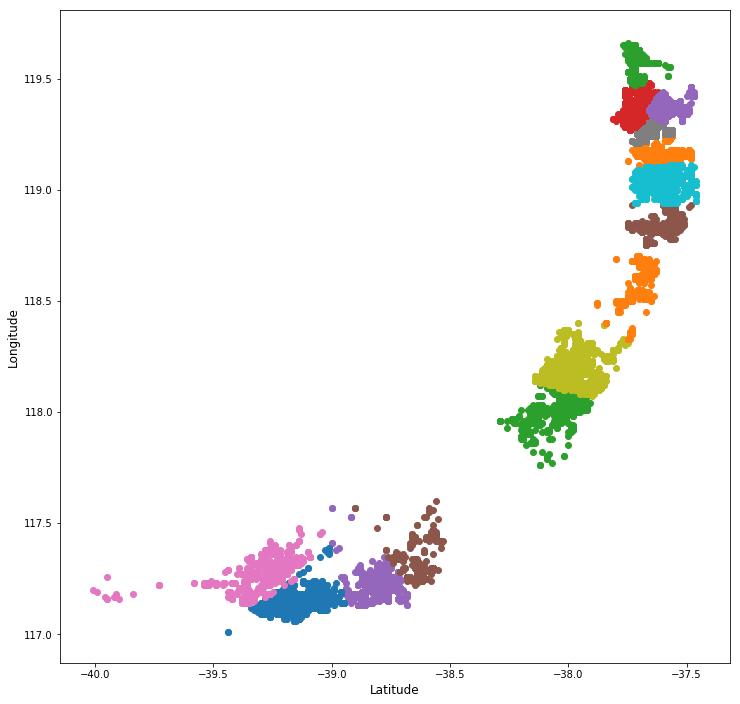

In [25]:
colors = ['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^']
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.scatter(X.lat[cluster].values,X.lon[cluster].values)#,colors[i])

In [26]:
def df_kmeans(df1,df2):
    df_con=pd.concat([df1[['lat','lon']],df2[['lat','lon']]])
    id_n=5
    kmeans = KMeans(n_clusters=id_n, random_state=0).fit(df_con)
    id_label=kmeans.labels_
    plt.figure(figsize=(10,12))
    plt.ylabel('Longitude', fontsize=12)
    plt.xlabel('Latitude', fontsize=12)
    for i in range(id_n):
        cluster=np.where(id_label==i)[0]
        plt.scatter(X.lat[cluster].values,X.lon[cluster].values)
    df1['kmean']=id_label[:len(df1)]
    df2['kmean']=id_label[len(df1):]
    cat_columns = ["kmean"]
    df1 = pd.get_dummies(df1, prefix_sep="_",columns=cat_columns)
    df2 = pd.get_dummies(df2, prefix_sep="_",columns=cat_columns)
    df1.drop(['lon','lat'],axis=1,inplace=True)
    df2.drop(['lon','lat'],axis=1,inplace=True)
    return df1,df2

/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


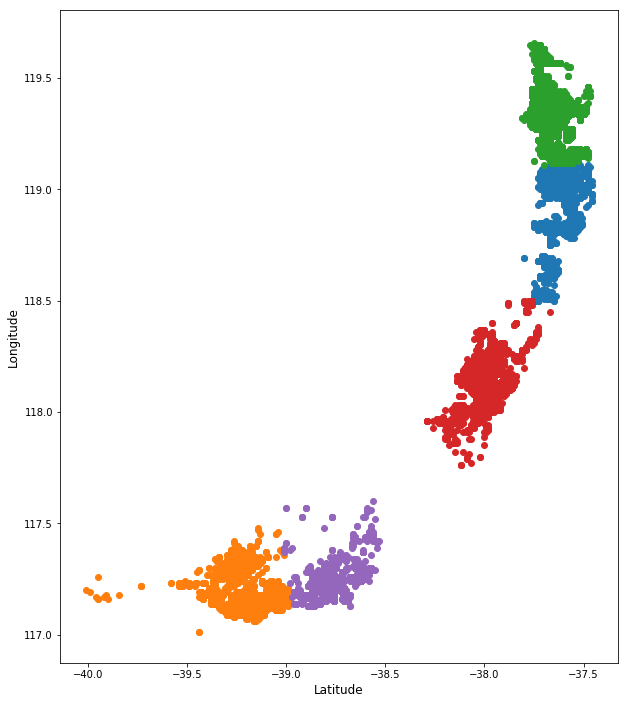

In [27]:
df_train_k,df_test_k=df_kmeans(train_df,test_df)

Nan Data 
---

In [29]:
def fillnan(df_1,df_2,features):
    df_1[features[0]].fillna(value=0,inplace=True)
    df_2[features[0]].fillna(value=0,inplace=True)
    df_1[features[1]].fillna(value=0,inplace=True)
    df_2[features[1]].fillna(value=0,inplace=True)
    
    df=pd.concat([df_1[features],df_2[features]],axis=0)
    for f in features[2:]:
        df_1[f].fillna(value=df[f].median(),inplace=True)
        df_2[f].fillna(value=df[f].median(),inplace=True)
    return df_1,df_2



In [30]:
nan_features=['parking_area','parking_price','txn_floor','village_income_median']

df_train_k,df_test_k=fillnan(df_train_k,df_test_k,nan_features)

In [31]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor

In [32]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [33]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#Validation function
n_folds = 5

def rmsle_cv(model,X,y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [34]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0001, random_state=1,tol=0.01))

# y➡︎ log(1+y)

In [ ]:
y = np.log1p(df_train_k['total_price'])
X=df_train_k.iloc[:len(y), 1:-1]

In [303]:
from scipy import stats
from scipy.stats import norm, skew 
def dist_check(y,kind='log1p'):
    if kind=='log1p':
       y_c=np.log1p(y)
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    sns.distplot(y_c , fit=norm);
    (mu, sigma) = norm.fit(y_c)
    #print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu:$ {:.2f}, $\sigma:$ {:.2f} )'.format(mu, sigma)],fontsize=14,
            loc='best')
    plt.title('Convert by %s' %kind)
    plt.ylabel('Frequency')
    
    plt.subplot(122)
    #fig = plt.figure(figsize=[8,6])
    res = stats.probplot(y_c, plot=plt)

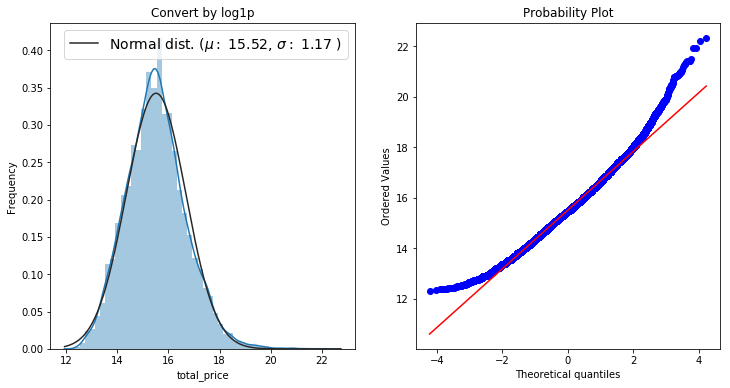

In [304]:
dist_check(df_train_k['total_price'])

So far, log(1+y) suits Gaussian distributed, (at least  (-1.96,1.96) 90%)

In [306]:

score = (rmsle_cv(lasso, X,y))
print("\nLasso score (alpha = {:.5f}): {:.4f} ({:.4f})\n".format(0.0001,score.mean(), score.std()))

/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Converge


Lasso score (alpha = 0.00010): 0.6893 (0.0224)



/Users/cch/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


**Let us try lightgbm,**

In [54]:
import lightgbm as lgb

lightgbm = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [57]:
y = np.log1p(df_train_k['total_price'])
X=df_train_k.iloc[:len(y), 1:-1]

In [58]:
score = rmsle_cv(lightgbm, X,y)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

lightgbm: 0.1057 (0.0015)



In [ ]:
lightgbm.fit(X,y)

In [60]:
yp=lightgbm.predict(X)

In [62]:
np.mean(yp),np.mean(y)

(15.518600724682534, 15.51863659056812)

In [63]:
# convert target back 
yp1=np.expm1(yp)
y1=np.expm1(y)

Score
---
$y,y_p$: true values, predicted values
\begin{eqnarray}
\mathbf{\hat Z}&=&1 &\text{ if } \left|\frac{ y- y_p}{ y}\right|<0.1,\text{ else } 0\\
\text{ Hit Rate } &=&\text{Mean}(\mathbf{\hat Z})\\
\text{ Score } &=& (\text{Hit Rate})\times 10^4+(1-\text{ Hit Rate })
\end{eqnarray}

In [42]:
def score_(y,yp):
    hit=sum(np.abs((y-yp))/y<0.1)/len(y)
    
    score=np.round(hit,4)*1e4+(1-np.round(hit,4))
    return score

In [67]:
score_(y1,yp1)

7509.2491

Submission
---

In [ ]:
submission=pd.read_csv('../dataset/submit_test.csv')

In [ ]:
def sumbit(df,yp0,output="../output/sub.csv"):
    df['total_price']=np.expm1(yp0)
    df.to_csv(output,index=False)
    print("output had been saved in ",output )

In [ ]:
X=df_test_k.iloc[:len(df_test_k), 1:]
yp=lightgbm.predict(X)

In [ ]:
sumbit(submission,yp)